# Swahili News Classification using Transformers

This Jupyter notebook trains a Transformer-based model to classify Swahili news articles into 5 categories.

### Steps Covered:
1. Load and preprocess the dataset
2. Tokenize the text using a pre-trained model
3. Train a `BERT`-based classifier
4. Evaluate and make predictions
5. Generate submission file

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load Data
train_df = pd.read_csv(r"C:\IIT\NLP Project\Train.csv")
test_df = pd.read_csv(r"C:\IIT\NLP Project\Test.csv")

# Label Encoding
#LabelBinarizer converts the categorical labels (Kitaifa, Kimataifa, etc.) into one-hot encoded vectors.
#The transformed labels (y_train) will be used for model training.
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(train_df['category'])



# Tokenizer
1.Loads the pre-trained tokenizer for Swahili news classification.

2.This tokenizer splits text into tokens that the model understands.

# Model

1. Loads a pre-trained BERT model for sequence classification.
2. num_labels=5 ensures the model has 5 output classes.
3. ignore_mismatched_sizes=True ensures that any mismatched layers (e.g., different output layer sizes) are adjusted automatically.
4. Moves the model to GPU (if available) for faster training.

In [2]:
# Tokenizer & Model
#Loads the pre-trained tokenizer for Swahili news classification.
#This tokenizer splits text into tokens that the model understands.

from transformers import AutoModelForSequenceClassification
MODEL_NAME = "flax-community/bert-swahili-news-classification"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained("flax-community/bert-swahili-news-classification",num_labels=5,ignore_mismatched_sizes=True).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_binarizer.classes_)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))





Some weights of BertForSequenceClassification were not initialized from the model checkpoint at flax-community/bert-swahili-news-classification and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define a PyTorch Dataset class to:

1.Tokenize and prepare input text.

2.Convert labels to PyTorch tensors.

3.Support batching with DataLoader.

In [3]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        
        return item

## Train-Test split
1. Splits the dataset into 90% training and 10% validation.
2. Converts text data into NewsDataset objects.
3. Uses DataLoader to create batches for efficient training

In [4]:
# Split train/val
txt_train, txt_val, y_train, y_val = train_test_split(train_df['content'], y_train, test_size=0.1, random_state=42)

train_dataset = NewsDataset(txt_train.tolist(), y_train, tokenizer)
val_dataset = NewsDataset(txt_val.tolist(), y_val, tokenizer)
test_dataset = NewsDataset(test_df['content'].tolist(), tokenizer=tokenizer)

t_train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
t_val_loader = DataLoader(val_dataset, batch_size=16)
t_test_loader = DataLoader(test_dataset, batch_size=16)




# Training setup
1. Uses CrossEntropyLoss since it's a multi-class classification problem.
2. AdamW optimizer is used with a learning rate of 2e-5.

In [5]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

def train_model(model, train_loader, val_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")
    return model

model = train_model(model, t_train_loader, t_val_loader)



100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [40:43<00:00,  8.43s/it]


Epoch 1, Loss: 0.2774411446832377


100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [41:50<00:00,  8.66s/it]


Epoch 2, Loss: 0.15621625519325508


100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [41:40<00:00,  8.62s/it]

Epoch 3, Loss: 0.10282581504434347


In [6]:
# Prediction
model.eval()
all_preds = []
with torch.no_grad():
    for batch in t_test_loader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        all_preds.append(outputs.cpu().numpy())

import numpy as np
all_preds = np.vstack(all_preds)

submission_df = pd.DataFrame(all_preds, columns=label_binarizer.classes_)
submission_df.insert(0, 'test_id', test_df['swahili_id'])
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [7]:
submission_df=pd.read_csv(r"C:\Users\shash\submission.csv")
print(submission_df)

                                       test_id  Biashara  Burudani  Kimataifa  \
0     001dd47ac202d9db6624a5ff734a5e7dddafeaf2 -2.014363 -2.006317  -0.922799   
1     0043d97f7690e9bc02f0ed8bb2b260d1d44bad92 -2.099497 -2.399172  -2.583413   
2     00579c2307b5c11003d21c40c3ecff5e922c3fd8  4.268249 -2.522824  -1.619719   
3     00868eeee349e286303706ef0ffd851f39708d37 -2.292792 -1.737239  -0.199570   
4     00a5cb12d3058dcf2e42f277eee599992db32412  1.303291 -2.505981  -2.005262   
...                                        ...       ...       ...        ...   
1283  feb4b0ae88524c9cee3e50f2301d84a235f3c607 -2.349457 -1.824328  -0.535890   
1284  fecf3f14f47237e02721ed4baa4eb6c11abd239f -1.668876 -1.991906  -2.428705   
1285  feed09e13586d12139cd59bc20996a4d29706606 -2.326944 -2.305283  -2.496495   
1286  ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8 -1.950165 -2.357055  -2.549608   
1287  fffdd6f356ed5b8dba21717f60c53f6520e650ab -1.236806 -1.699160  -0.286405   

       Kitaifa   michezo  


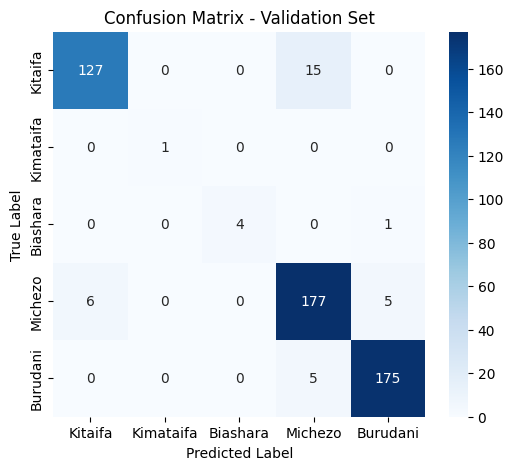

In [8]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract necessary components from the notebook's structure
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to compute validation predictions and generate confusion matrix
def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()  # True labels

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Predicted labels

            all_preds.extend(preds)
            all_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot to label indices

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Kitaifa", "Kimataifa", "Biashara", "Michezo", "Burudani"], 
                yticklabels=["Kitaifa", "Kimataifa", "Biashara", "Michezo", "Burudani"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Validation Set")
    plt.show()

# Run the function to generate the confusion matrix
evaluate_model(model, t_val_loader)


In [9]:
from sklearn.metrics import log_loss

def calculate_log_loss(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()  # True labels in one-hot format

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities

            all_probs.extend(probs)
            all_labels.extend(labels)  # Already in one-hot encoding

    # Compute Log Loss
    log_loss_value = log_loss(all_labels, all_probs)
    print(f"Log Loss on Validation Set: {log_loss_value:.4f}")

# Run the function
calculate_log_loss(model, t_val_loader)


Log Loss on Validation Set: 0.2275


C:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [10]:
from sklearn.metrics import log_loss, accuracy_score

def evaluate_model_metrics(model, val_loader):
    model.eval()  # Set model to evaluation mode
    all_probs, all_preds, all_labels = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()  # True labels (one-hot encoded)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert logits to probabilities
            preds = np.argmax(probs, axis=1)  # Get predicted class labels
            true_labels = np.argmax(labels, axis=1)  # Convert one-hot labels to indices

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(true_labels)

    # Compute Log Loss
    log_loss_value = log_loss(all_labels, all_probs)

    # Compute Accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Log Loss on Validation Set: {log_loss_value:.4f}")
    print(f"Accuracy on Validation Set: {accuracy * 100:.2f}%")

# Run the function
evaluate_model_metrics(model, t_val_loader)


Log Loss on Validation Set: 0.2275
Accuracy on Validation Set: 93.80%


C:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
